# **Assigment $|02\rangle$ 🔐 Shor's Algorithm 🔐** &nbsp;[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/18520339/uts-quantum-computing/blob/main/assignment2_shor_algorithm/shor_algorithm.ipynb)

[![image](https://github.com/18520339/uts-quantum-computing/assets/50880271/e0588281-1148-4acb-a4cd-54fecd46c2ce)](https://rand.cs.uchicago.edu/publication/peng-2022-shor/)

In [ ]:
!pip install qiskit --quiet
!pip install qiskit-aer --quiet
!pip install pylatexenc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


**Shor's algorithm** can be divided into 2 main parts:
1. **Classical Part**: This involves reducing the problem of factorizing an integer $N$ to the problem of finding the period $r$ of a specific function.
2. **Quantum Part**:
- This involves using a quantum computer to **find the period $r$** efficiently. The algorithm creates a superposition of states to encode information about the period into the quantum state.
- The **Quantum Fourier Transform (QFT)** is applied to the quantum state to extract the period $r$:

    $$\left| \tilde{x} \right\rangle = QFT_N \vert x \rangle = \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1}  e^{2\pi i \frac{xk}{N}} \vert k \rangle$$
    $$\text{where N = number of qubits; } \vert k \rangle = \vert k_1 k_2 \cdots k_n \rangle (\text{binary qbuit state })$$

 - It is a series of **Hadamard** and **Controlled Phase Rotation** gates to the output state of the **Modular Exponentiation** circuit. This transforms the state into a form where measuring the qubits can yield the period $r$ (just a change of basis).
 - This **Modular Exponentiation** is crucial for creating the periodic function. It involves applying a series of **controlled-U** gates, where $U$ represents modular multiplication.

**The steps are as follows**:
1. **Choose a Random Number $a$**: Select a random integer $a$ such that $1 < a < N$.
2. **Check if $N$ is valid**: If $N$ is even or a prime number or a power of a prime number, then $N$ is not valid for factorization.
3. **Compute the Greatest Common Divisor (GCD)**: Compute $\text{gcd}(a, N)$. If $\text{gcd}(a, N) \neq 1$, then $\text{gcd}(a, N)$ is a non-trivial factor of $N$.
4. **Quantum Period Finding**: Use a quantum computer to **find the period $r$** of the function $f(x) = a^x \mod N$.
5. **Check the Period**: If $r$ is even and $a^{r/2} \pm 1$ is not a multiple of $N$, then compute $\text{gcd}(a^{r/2} \pm 1, N)$ to obtain the factors of $N$.

👉 If the above steps do not yield factors, repeat the process with a different $a$.

In [ ]:
# @markdown ### **1. Import `Qiskit` and essential packages** { display-mode: "form" }
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator

from fractions import Fraction
import random
import sympy
import math

In [ ]:
# @markdown ### **2. Controlled Modular Multiplication for $U(x) = a^x mod N$** { display-mode: "form" }
class CtrlMultCircuit(QuantumCircuit):
    def __init__(self, a, binary_power, N):
        super().__init__(N.bit_length())
        self.a = a
        self.power = 2 ** binary_power # Convert binary to decimal
        self.N = N
        self.name = f'{self.a}^{self.power} mod {self.N}'
        self._create_circuit()

    def _create_circuit(self):
        for dec_power in range(self.power):
            a_exp = self.a ** dec_power % self.N
            for i in range(self.num_qubits):
                if a_exp >> i & 1: self.x(i)
                for j in range(i + 1, self.num_qubits):
                    if a_exp >> j & 1: self.swap(i, j)

In [ ]:
# @markdown ### **3. Quantum Phase Estimation with `Modular Exponentiation` and `Quantum Fourier Transform` to find period $r$** { display-mode: "form" }
# @markdown ![](https://reneroliveira.github.io/quantum-shors-algorithm/images/shor_circuit.png)

class QPECircuit(QuantumCircuit):
    def __init__(self, a, N):
        super().__init__(2 * N.bit_length(), N.bit_length())
        self.a = a
        self.N = N
        self._create_circuit()

    def _modular_exponentiation(self):
        for qbit_idx in range(self.num_qubits // 2):
            self.append(
                CtrlMultCircuit(self.a, qbit_idx, self.N).to_gate().control(),
                [qbit_idx] + list(range(self.num_qubits // 2, 2 * self.num_qubits // 2))
            )

    def _create_circuit(self):
        self.h(range(self.num_qubits // 2)) # Apply Hadamard gates to the first n qubits
        self.x(self.num_qubits - 1)
        self.barrier()

        self._modular_exponentiation() # Apply controlled modular exponentiation
        self.barrier()
        self.append(
            QFT(self.num_qubits // 2, inverse=True),
            range(self.num_qubits // 2) # Apply inverse QFT to the first n qubits
        )

    def collapse(self, simulator):
        self.measure(range(self.num_qubits // 2), range(self.num_qubits // 2))
        transpiled_circuit = transpile(self, simulator)
        self.collapse_result = simulator.run(transpiled_circuit, memory=True).result()
        return self.collapse_result

This is at the heart of Shor's algorithm. It estimates the **eigenvalue** corresponding to an **eigenstate** of a **unitary operator**. In this case, I use it to estimate the phase $\phi$ related to the order $r$.

1. **Initialize qubits**: I start with an equal superposition of all possible states.
2. **Apply controlled-unitary operations**: These operations encode the **Modular Exponentiation** into the qubits.
3. **Inverse QFT**: Apply the inverse $QFT^{-1} = \frac{1}{\sqrt{2^n}} \sum_{j,k=0}^{2^n-1} e^{-2\pi i jk / 2^n} |j\rangle \langle k|$ to the qubits to extract the phase information.

In [ ]:
# @markdown ### **4. Completed Shor's Algorithm for Integer Factorization** { display-mode: "form" }
class ShorAlgorithm:
    def __init__(self, N, max_attempts=-1, random_coprime_only=False, simulator=None):
        self.N = N
        self.simulator = simulator
        self.max_attempts = max_attempts # -1 for all possible values of a
        self.random_coprime_only = random_coprime_only # True to select only coprime values of a and N


    def execute(self):
        is_N_invalid = self._is_N_invalid()
        if is_N_invalid: return is_N_invalid
        
        # Only coprime values remain if random_coprime_only is enabled, 
        # Otherwise select a random integer in [2, N) as initial guess
        a_values = [a for a in range(2, self.N) if not self.random_coprime_only or (math.gcd(a, self.N) == 1)]
        self.max_attempts = len(a_values) if self.max_attempts <= -1 else min(self.max_attempts, len(a_values))
        attempts_count = 0

        while attempts_count < self.max_attempts:
            print(f'\n===== Attempt {attempts_count + 1}/{self.max_attempts} =====')
            attempts_count += 1
            self.chosen_a = random.choice(a_values)
            self.r = 1

            print(f'[START] Chosen base a: {self.chosen_a}')
            if self.random_coprime_only:
                gcd = math.gcd(self.chosen_a, self.N)
                if gcd != 1:
                    print(f'=> {self.chosen_a} and {self.N} share common factor: {self.N} = {gcd} * {self.N // gcd}')
                    return gcd, self.N // gcd

            print(f'>>> {self.chosen_a} and {self.N} are coprime => Perform Quantum Phase Estimation to find {self.chosen_a}^r - 1 = 0 (MOD {self.N})')
            if not self._quantum_period_finding():
                a_values.remove(self.chosen_a)
                self.r = self.chosen_a = self.qpe_circuit = None
                continue

            factors = self._classical_postprocess()
            if factors: return factors
            a_values.remove(self.chosen_a)
            self.r = self.chosen_a = self.qpe_circuit = None
        print(f'[FAIL] No non-trivial factors found after {self.max_attempts} attempts.')


    def _is_N_invalid(self):
        if self.N <= 3:
            print('[ERR] N must be > 3')
            return 1, self.N

        if self.N % 2 == 0:
            print(f'=> {self.N} is an even number: {self.N} = 2 * {self.N // 2}')
            return 2, self.N // 2
        
        if sympy.isprime(self.N):
            print(f'=> {self.N} is a prime number: {self.N} = 1 * {self.N}')
            return 1, self.N
        
        max_exponent = int(math.log2(self.N)) # Start with a large exponent and reduce
        for k in range(max_exponent, 1, -1):
            p = round(self.N ** (1 / k))
            if p ** k == self.N: 
                print(f'=> {self.N} is a power of prime: {self.N} = {p}^{k}')
                return p, k
        return False
    
    
    def _quantum_period_finding(self):
        while self.chosen_a ** self.r % self.N != 1: # QPE + continued fractions may find wrong r
            self.qpe_circuit = QPECircuit(self.chosen_a, self.N) # Find phase s/r
            result = self.qpe_circuit.collapse(self.simulator)
            state_bin = result.get_memory()[0]
            state_dec = int(state_bin, 2) # Convert to decimal
            bits_count = 2 ** (self.N.bit_length() - 1)
            phase = state_dec / bits_count

            # Continued fraction to find r
            self.r = Fraction(phase).limit_denominator(self.N).denominator # Get fraction that most closely approximates phase
            if self.r > self.N or self.r == 1: # Safety check to avoid infinite loops
                print(f'[ERR] Invalid period found: r = {self.r} => Retry with different a.')
                return False

        print(f'>>> Output State: |{state_bin}⟩ = {state_dec} (dec) => Phase = {state_dec} / {bits_count} = {phase:.3f}')
        return True


    def _classical_postprocess(self):
        # Classical postprocessing to find factors from the period
        print(f'>>> Found r = {self.r} => a^{{r/2}} ± 1 = {self.chosen_a:.0f}^{self.r/2:.0f} ± 1')

        if self.r % 2 != 0:
            print(f'[ERR] r = {self.r} is odd => Retry with different a.')
            return None

        int1, int2 = self.chosen_a ** (self.r // 2) - 1, self.chosen_a ** (self.r // 2) + 1
        if int1 % self.N == 0 or int2 % self.N == 0:
            print(f'[ERR] {self.chosen_a}^{self.r/2:.0f} ± 1 is a multiple of {self.N} => Retry with different a.')
            return None

        factor1, factor2 = math.gcd(int1, self.N), math.gcd(int2, self.N)
        if factor1 not in [1, self.N] and factor2 not in [1, self.N]: # Check to see if factor is non-trivial
            print(f'[DONE] Successfully found non-trivial factors: {self.N} = {factor1} * {factor2}')
            return factor1, factor2

        print(f'[FAIL] Trivial factors found: [1, {self.N}] => Retry with different a.')
        return None

By measuring the state after applying the **inverse QFT**, I obtain the phase $\phi$, from which I can deduce the order $r$: $\phi = \frac{s}{r} \implies r \approx \frac{1}{\phi}$

The continued fraction representation of a rational number $\frac{p}{q}$ helps in extracting the period $r$ from the phase $\frac{s}{r}$.

$$\frac{p}{q} = a_0 + \cfrac{1}{a_1 + \cfrac{1}{a_2 + \cfrac{1}{\ddots + \cfrac{1}{a_n}}}}$$

Using the order $r$, I apply **classical postprocessing** to find the factors of $N$. If $r$ is even and $x^{r/2} \neq \pm 1 \text{ (mod N)}$, then the factors are given by: $\gcd(x^{r/2} \pm 1, N)$.


===== Attempt 1/11 =====
[START] Chosen base a: 20
>>> 20 and 21 are coprime => Perform Quantum Phase Estimation to find 20^r - 1 = 0 (MOD 21)
>>> Output State: |00111⟩ = 7 (dec) => Phase = 7 / 16 = 0.438
>>> Found r = 16 => a^{r/2} ± 1 = 20^8 ± 1
[ERR] 20^8 ± 1 is a multiple of 21 => Retry with different a.

===== Attempt 2/11 =====
[START] Chosen base a: 5
>>> 5 and 21 are coprime => Perform Quantum Phase Estimation to find 5^r - 1 = 0 (MOD 21)
[ERR] Invalid period found: r = 1 => Retry with different a.

===== Attempt 3/11 =====
[START] Chosen base a: 13
>>> 13 and 21 are coprime => Perform Quantum Phase Estimation to find 13^r - 1 = 0 (MOD 21)
>>> Output State: |01100⟩ = 12 (dec) => Phase = 12 / 16 = 0.750
>>> Found r = 4 => a^{r/2} ± 1 = 13^2 ± 1
[ERR] 13^2 ± 1 is a multiple of 21 => Retry with different a.

===== Attempt 4/11 =====
[START] Chosen base a: 8
>>> 8 and 21 are coprime => Perform Quantum Phase Estimation to find 8^r - 1 = 0 (MOD 21)
>>> Output State: |01000⟩ = 8 (dec

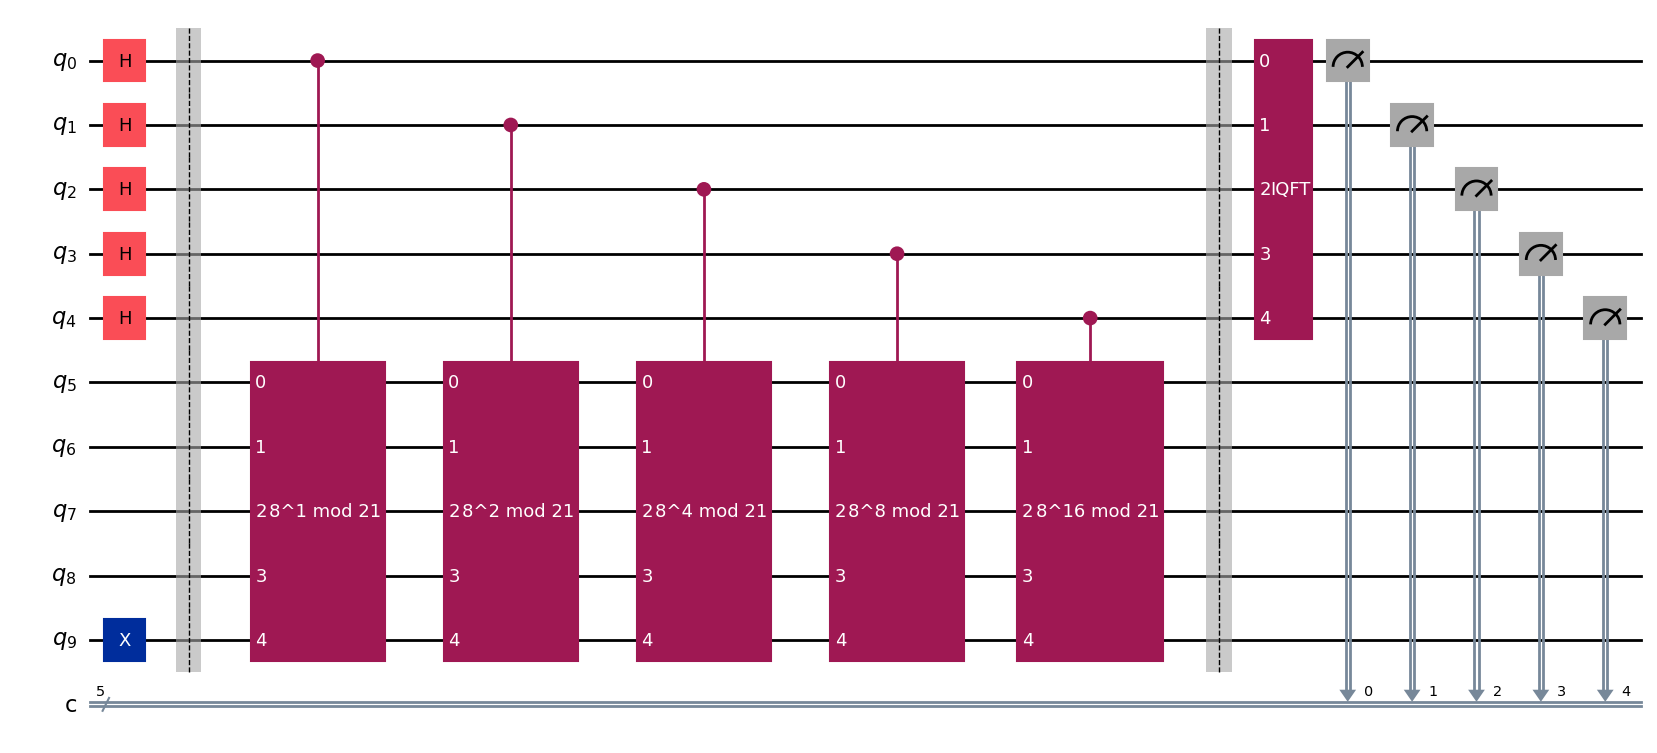

In [ ]:
# @markdown ### **5. Run the Factorization** { display-mode: "form" }
number_to_factor = 21 # @param {type:"slider", min: 15, max: 55, step: 1}
max_attempts = -1 # @param {type:"slider", min:-1, max:100, step:10}
random_coprime_only = False # @param {type:"boolean"}
# @markdown ***Note**: `max_attempts` will be limited to number of available values.

shor = ShorAlgorithm(number_to_factor, max_attempts, random_coprime_only, AerSimulator())
factors = shor.execute()
try: display(shor.qpe_circuit.draw(output='mpl', fold=-1))
except Exception: pass